In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)
# sklearn ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import seaborn as sns
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "regression"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

import platform
from matplotlib import font_manager, rc
#매킨토시의 경우
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
    mpl.rcParams['axes.unicode_minus'] = False
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
        plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
#데이터 가져오기
bike_df = pd.read_csv('./bike-sharing-demand/train.csv')
print(bike_df.shape)
bike_df.head()
bike_df.info()

(10886, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

In [6]:
#날짜를 년 월 일 시간으로 분할
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [7]:
#불필요한 컬럼 제거
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

In [8]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   count       10886 non-null  int64  
 9   year        10886 non-null  int64  
 10  month       10886 non-null  int64  
 11  day         10886 non-null  int64  
 12  hour        10886 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 1.1 MB


In [14]:
#downcasting 함수
def downcast(df):
    #메모리 사용량 확인
    start_mem = df.memory_usage().sum() / 1024 * 2
    
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            #pandas에는 downcasting을 해주는 함수가 존재
            df[col] = pd.to_numeric(df[col], downcast = 'integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast = 'float')
            
    end_mem = df.memory_usage().sum() / 1024
    
    print(100 * (start_mem - end_mem) / start_mem, "% 압축됨")
    return df

bike_df = downcast(bike_df)

50.0 % 압축됨


In [15]:
import gc
gc.collect()

2449

In [16]:
# 평가 지표를 위한 함수
from sklearn.metrics import mean_squared_error, mean_absolute_error

#rmsle를 구해주는 함수
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

## 단순 선형 회귀 수행

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,
                                                    random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.165, RMSE: 140.899, MAE: 105.925


C:\Users\user\AppData\Local\Temp\ipykernel_16172\2232863961.py:7: RuntimeWarning: invalid value encountered in log1p
  log_pred = np.log1p(pred)


In [20]:
#오차가 큰 값 확인
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성.
    result_df = pd.DataFrame(y_test.values, columns=['실제 대여 횟수'])
    result_df['예측한 대여 횟수']= np.round(pred)
    result_df['차이'] = np.abs(result_df['실제 대여 횟수'] - result_df['예측한 대여 횟수'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력.
    print(result_df.sort_values('차이', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5)

      실제 대여 횟수  예측한 대여 횟수     차이
1618       890      322.0  568.0
3151       798      241.0  557.0
966        884      327.0  557.0
412        745      194.0  551.0
2817       856      310.0  546.0


## 타겟에 로그 변환 후 모델을 다시 훈련

<Axes: >

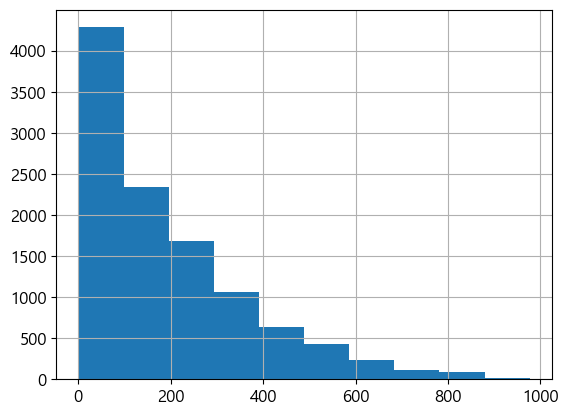

In [21]:
#분포 확인
y_target.hist()

<Axes: >

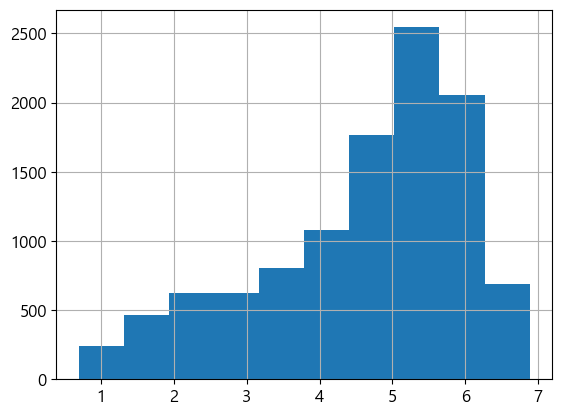

In [22]:
# 타겟의 로그 변환
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [23]:
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3,
                                                    random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 로그 변환한 타겟의 값을 원래의 값으로 되돌려야 함
# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)
# 예측 값 역시 Log 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


## 피처를 원 핫 인코딩한 후 수행

<Axes: >

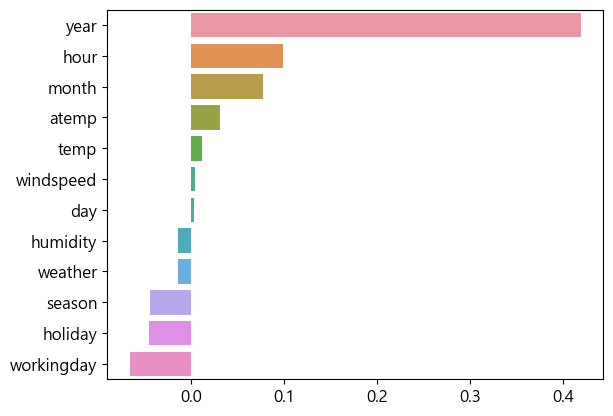

In [24]:
# 회귀 계수 확인
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)


import seaborn as sns
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [25]:
# 원 핫 인코딩
X_features_ohe = pd.get_dummies(X_features , columns=['year', 'month', 'day', 'hour', 'holiday',
                                                      'workingday', 'season', 'weather'])
X_features_ohe

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395000,81,0.000000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635000,80,0.000000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635000,80,0.000000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395000,75,0.000000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395000,75,0.000000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695000,50,26.002701,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10882,14.76,17.424999,57,15.001300,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10883,13.94,15.910000,61,15.001300,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10884,13.94,17.424999,61,6.003200,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=42)

In [27]:
#모델과 데이터를 받아서 훈련하고 평가 지표를 출력하는 함수
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
        
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

In [29]:
lr_reg = LinearRegression()
get_model_predict(lr_reg, X_train, X_test, y_train, y_test, is_expm1 = True)

### LinearRegression ###
RMSLE: 0.587, RMSE: 98.023, MAE: 63.486


## 규제 모델을 이용한 훈련

In [31]:
from sklearn.linear_model import Ridge, Lasso

#alpha 값을 줄이면 성능이 좋아짐
#일반적으로 규제 모델을 사용하면 선형 회귀보다는 성능이 좋아질 가능성이 높음
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

get_model_predict(ridge_reg, X_train, X_test, y_train, y_test, is_expm1 = True)
get_model_predict(lasso_reg, X_train, X_test, y_train, y_test, is_expm1 = True)

### Ridge ###
RMSLE: 0.587, RMSE: 96.827, MAE: 62.889
### Lasso ###
RMSLE: 0.639, RMSE: 112.044, MAE: 71.914


## 트리 모델 적용

In [33]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# 랜덤 포레스트, GBM, XGBoost model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)


### RandomForestRegressor ###
RMSLE: 0.350, RMSE: 47.942, MAE: 29.952
### GradientBoostingRegressor ###
RMSLE: 0.331, RMSE: 51.715, MAE: 32.199
### XGBRegressor ###
RMSLE: 0.344, RMSE: 50.529, MAE: 31.145
